In [4]:
import pandas as pd
import numpy as np
import warnings
import os
from datetime import datetime, timedelta
import seaborn as sns
import xgboost as xgb
from lightgbm import LGBMRegressor
from scipy import stats
from sklearn.ensemble import GradientBoostingRegressor

import matplotlib.pyplot as plt
from statsmodels.tsa.deterministic import CalendarFourier,DeterministicProcess
from statsmodels.graphics.tsaplots import plot_pacf

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import  r2_score, root_mean_squared_error as RMSE, mean_absolute_percentage_error as MAPE, root_mean_squared_log_error as RMSLE
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV, RandomizedSearchCV

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import STL

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)

In [5]:
Holiday_events = pd.read_csv("D:\Data_Science\Time Series Forecasting\store-sales-time-series-forecasting (1)\holidays_events.csv", parse_dates=["date"])
Oil = pd.read_csv("D:\Data_Science\Time Series Forecasting\store-sales-time-series-forecasting (1)\oil.csv", parse_dates=["date"])
stores = pd.read_csv("D:\Data_Science\Time Series Forecasting\store-sales-time-series-forecasting (1)\stores.csv")
transactions = pd.read_csv("D:\Data_Science\Time Series Forecasting\store-sales-time-series-forecasting (1)\\transactions.csv", parse_dates=["date"])
train =  pd.read_csv("D:\Data_Science\Time Series Forecasting\store-sales-time-series-forecasting (1)\\train.csv", parse_dates=["date"])
test = pd.read_csv("D:\Data_Science\Time Series Forecasting\store-sales-time-series-forecasting (1)\\test.csv", parse_dates=["date"])

In [6]:
pd.set_option("display.float_format", lambda x:"%.3f"%x)

In [7]:
train.shape

(3000888, 6)

In [8]:
train.isnull().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [9]:
Oil.isnull().sum()

date           0
dcoilwtico    43
dtype: int64

In [10]:
transactions.isnull().sum()

date            0
store_nbr       0
transactions    0
dtype: int64

In [11]:
stores.isnull().sum()

store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

In [12]:
def string_processing(data, columns):
    '''
    data : Table for transformation
    columns : list of string columns
    '''
    for i in columns:
        data[i] = data[i].str.strip().str.upper()
    return data

In [13]:
def Holiday_func(tbl):
    """
    tbl : Holiday table
    """
    Local = tbl[tbl["locale"] == 'Local']
    Regional = tbl[tbl["locale"] == 'Regional']
    National = tbl[tbl["locale_name"].str.contains('Ecuador')]
    prefix = ["Local_","Regional_","National_"]
    diff_type = [Local, Regional, National]
    for i in range(3):
        diff_type[i] = diff_type[i][["date", "locale_name","type"]]
        diff_type[i]["values"] = 1
        diff_type[i]["type"] = prefix[i] + diff_type[i]["type"]
        diff_type[i].drop_duplicates(inplace=True)
        diff_type[i] = diff_type[i].pivot_table(index=["date", 'locale_name'], columns=["type"], values="values",aggfunc='mean', fill_value=0).reset_index()
        diff_type[i] = string_processing(diff_type[i], ['locale_name'])
    
    return diff_type[0], diff_type[1], diff_type[2]


In [14]:
def merge_tables(data,transactions, Oil, stores, National, Local, Regional):
    """
    data : Base transaction table
    transactions : transactions over the years
    Oil : Oil prices over the years 
    stores : Store details table
    National : National Event Table
    Local : Local Event Table
    Regional : Regional Event Table
    """
    input1 = pd.merge(data, transactions, left_on = ["date", "store_nbr"], right_on=["date","store_nbr"], how = "left")
    input2 = pd.merge(input1, Oil, on = ["date"], how="left")
    input3 = pd.merge(input2, stores, on = ["store_nbr"], how="left")
    input4 = pd.merge(input3, National, left_on = 'date', right_on='date', how = 'left')
    input4 = pd.merge(input4, Local, left_on=["date", "city"], right_on=["date","locale_name"], how="left")
    input4 = pd.merge(input4, Regional, left_on=["date", "state"], right_on=["date","locale_name"], how="left")
    input4["dcoilwtico"] = input4["dcoilwtico"].ffill().bfill()
    input4.drop(columns=["transactions"], inplace=True)
    input4.fillna(0, inplace=True)
    
    return input4

In [15]:
def date_treatment(data):

    '''
    Data : Table with a date column
    '''

    data["week_num"] = data["date"].dt.strftime("%V")
    data["Day_Name"] = data["date"].dt.day_name()
    data["Month"] = data["date"].dt.month
    data["Year"] = data["date"].dt.year
    data["Month_End"] = data["date"] + pd.offsets.MonthEnd(0)
    data["Month_Begin"] = data["date"] - pd.offsets.MonthBegin(0)
    data.loc[data["date"] != data["Month_Begin"], "Month_Begin"] = 0
    data.loc[data["date"] == data["Month_Begin"], "Month_Begin"] = 1
    data.loc[data["date"] != data["Month_End"], "Month_End"] = 0
    data.loc[data["date"] == data["Month_End"], "Month_End"] = 1
    Day_Name_Dummies = pd.get_dummies(data["Day_Name"], dtype='int')
    data["week_num"] = data["week_num"].astype('int')
    data["Month_End"] = data["Month_End"].astype('int')
    data["Month_Begin"] = data["Month_Begin"].astype('int')
    data = pd.concat([data, Day_Name_Dummies], axis=1)
    
    return data

In [16]:
def add_lag_features(df):
    '''
    df : table with sales
    '''
    for lag in range(1, 8):
        df[f'lag_{lag}'] = df['sales'].shift(lag*1782)
    return df.dropna()


In [17]:
def make_lags(data, clm,lags,idx):
    '''
    data : table with columns which are there in clm
    lags : Number of lags
    clm : Column where lags need to be applied
    idx : index for the dataframe
    '''
    lag_data = pd.DataFrame()
    for i in range(1,lags+1):
        lag_1 = data[[clm]].shift(i)
        lag_1.rename(columns = {clm:f"lag_{i}"}, inplace=True)
        lag_data = pd.concat([lag_data, lag_1], axis = 1)
    lag_data.index = idx
    lag_data.dropna(inplace=True)
    return lag_data

def make_multistep_target(ts, steps):
    '''
    ts : numpy array with the values
    steps : Number of steps we want to predict ahead
    '''
    return pd.concat(
        {f'y_step_{i + 1}': ts.shift(-i)
         for i in range(steps)},
        axis=1)

In [18]:
##result = pd.DataFrame()
##for k in range(1, max(train["store_nbr"]) + 1):
##    store_1 = train[train["store_nbr"] == k][["date", "store_nbr","family", "sales"]]
##    family_sales_pvt = store_1.pivot_table(columns=["family"], index = ["date","store_nbr"], aggfunc = "sum", values="sales").reset_index()
##    lags = dict()
##    for j in range(1,8):
##        family_sales_pvt_copy = family_sales_pvt.copy()
##        for i in family_sales_pvt.columns[2:]:
##            family_sales_pvt_copy[i] = family_sales_pvt_copy[i].shift(j)
##        lags[f"lag_{j}"] = family_sales_pvt_copy.melt(id_vars = ["date", "store_nbr"], value_vars = family_sales_pvt.columns[2:], value_name = f"lag_{j}")
##        if j == 1:
##            family_lag = lags["lag_1"]
##        else:
##            family_lag = pd.merge(family_lag, lags[f"lag_{j}"], on = ["date", "family","store_nbr"])
##    result = pd.concat([result,family_lag], axis=0)

In [19]:
## Data to make lag
def make_future_lags(train,str_nbr, ctgry):
    
    '''
    str_nbr : List of all the store numbers
    train : Train dataset
    ctgry : List of product family

    '''

    store_data = train[(train["store_nbr"] == str_nbr) & (train["family"] == ctgry)][["date", "store_nbr","family", "sales"]]
    ## 16 step ahead forecast
    store_m_step = make_multistep_target(store_data["sales"], steps=16)
    store_m_step.index = store_data["date"]
    store_m_step.dropna(inplace=True)
    ## lag for store data
    store_1_lag = make_lags(store_data,"sales",7,store_data["date"])
    ## common points
    y_step, X_step = store_m_step.align(store_1_lag, join="inner", axis = 0)

    model = LinearRegression()
    model.fit(X_step, y_step)

    forecast_horizon = store_1_lag.iloc[-1:,:]
    forecast_result = pd.DataFrame(model.predict(forecast_horizon), index = forecast_horizon.index, columns=y_step.columns)

    ## Actual vs prediction comparison
    
    Forecast_Sale = pd.DataFrame({"sales":forecast_result.iloc[-1].reset_index(drop=True)},)
    Forecast_Sale.index = pd.period_range(start="2017-08-16", end = "2017-08-31")
    prev_sales = pd.DataFrame({"sales":store_data["sales"][-15:].reset_index(drop = True)})
    prev_sales.index = pd.period_range(start="2017-08-01", end = "2017-08-15")

    forecast_data = pd.concat([prev_sales,Forecast_Sale], axis = 0)

    forecast_lag = make_lags(forecast_data, "sales", 7, forecast_data.index)

    forecast_lag = forecast_lag.iloc[-16:,:]
    forecast_lag.reset_index(inplace=True)
    forecast_lag.rename(columns={"index":"date"}, inplace=True)
    forecast_lag["store_nbr"] = str_nbr
    forecast_lag["family"] = ctgry

    return forecast_lag

In [20]:
def lag_for_prediction(train):
    
    '''
    
    train : train dataset

    '''

    lag_for_forecast = pd.DataFrame()
    stores_number = [i for i in train["store_nbr"].unique()]
    families = [j for j in train["family"].unique()]
    for str in stores_number:
        for fam in families:
            forecast_lag = make_future_lags(train,str,fam)
            lag_for_forecast = pd.concat([lag_for_forecast, forecast_lag], axis = 0)

    lag_for_forecast["date"] = lag_for_forecast["date"].dt.to_timestamp()

    return lag_for_forecast

In [21]:
def fourier_features(index, freq, order):
    '''
    
    index : Date index
    freq : frequenct of the seasonality
    order : order of fourier features

    '''
    time = np.arange(len(index), dtype=np.float32)
    k = 2 * np.pi * (1/freq) * time
    features = {}
    
    for i in range(1, order + 1):
        features.update({
            f"sin_{freq}_{i}":np.sin(i*k),
            f"cos_{freq}_{i}":np.cos(i*k)
            })
    
    return pd.DataFrame(features, index=index)

In [22]:
from scipy.signal import periodogram

def plot_periodogram(ts, detrend='linear', ax=None):
    '''
    ts : Sales with timeseries index
    '''
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")

    return ax

- Strong Weekly seasonality, along with little semiweekly, yearly seasonality

<Axes: title={'center': 'Periodogram'}, ylabel='Variance'>

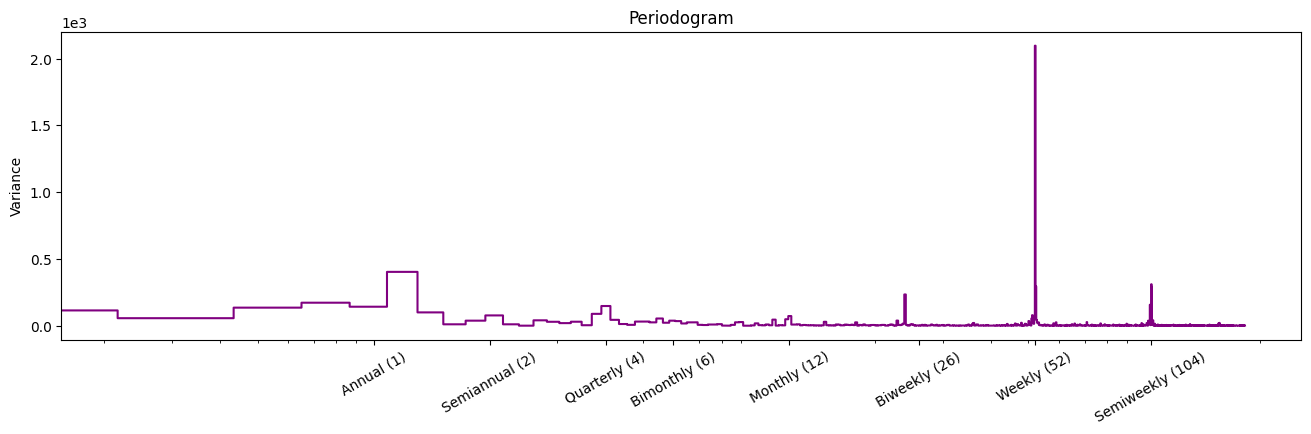

In [23]:
fig, axs = plt.subplots(nrows = 1, ncols =1, figsize=(16,4))
plot_periodogram(train.groupby(by = ["date"])["sales"].mean(), ax = axs)

In [24]:
## To add seasonality in the data
def add_seasonality(period, freq, order):
    """
    period : period to calculate seasonality
    feq : Frequency of the seasonality
    order : Order of the seasonality
    """

    seasonality = pd.DataFrame()
    
    for i in freq:
        freq_seasonality = fourier_features(period, freq=i,order=order)
        seasonality = pd.concat([seasonality, freq_seasonality], axis=1)
    
    seasonality.reset_index(inplace=True)
    seasonality.rename(columns={"index":"date"}, inplace=True)
    seasonality["date"] = seasonality["date"].dt.to_timestamp()

    return seasonality

In [25]:
## To add trend line
def add_trend(tbl):
    '''
    tbl : Table with time period of sales
    '''
    
    num_list = np.array([i+1 for i in range(len(tbl))])
    sqr_list = np.square(num_list)

    trend_line = pd.DataFrame({"Trend":num_list,"Trend_Square":sqr_list})

    trend_line["date"] = tbl["date"]

    return trend_line

- Daily use items like Bread/Bakery, Polutary, Meats have greater sales
- Some of the stores has opened later after the 2013 like store_nbr = 53.
- Some products were introduced later in the time period (they could have expanded with time)
- Grocery is the most sold product in grocery stores followed by the beverages

In [26]:
def grp_statistics(data,grp):
    '''
    data : Sales table with the groups
    grp : Different groups in table
    '''
    statistics_input = data.groupby(by = grp)["sales"].describe().reset_index()
    statistics_input.sort_values(by = ["mean"], ascending = False, inplace=True)
    
    return statistics_input

In [27]:
statistics_input = grp_statistics(train,["store_nbr", "family"])
statistics_input.head(10)

,store_nbr,family,count,mean,std,min,25%,50%,75%,max
1431,44,GROCERY I,1684.000,9730.436,3576.086,0.000,7271.000,8804.000,11645.500,46271.000
1464,45,GROCERY I,1684.000,9708.878,3968.979,0.000,7062.750,8975.500,11664.500,76090.000
1530,47,GROCERY I,1684.000,9212.903,3213.630,0.000,6803.250,8537.500,11131.250,23024.000
1497,46,GROCERY I,1684.000,8516.783,3609.152,0.000,5767.250,7330.000,10650.500,25238.000
1422,44,BEVERAGES,1684.000,7967.850,3885.071,0.000,4618.250,7585.500,9608.750,25413.000
78,3,GROCERY I,1684.000,7702.178,2243.045,0.000,6140.750,7263.500,8985.250,21858.000
1563,48,GROCERY I,1684.000,7619.355,3454.844,0.000,5027.500,6446.500,9559.750,22255.000
1455,45,BEVERAGES,1684.000,6751.990,3813.373,0.000,3339.500,6249.500,8799.750,22170.000
69,3,BEVERAGES,1684.000,6740.849,3124.891,0.000,3910.250,6556.500,8407.750,19154.000
1596,49,GROCERY I,1684.000,6584.311,2576.109,0.000,4757.500,6309.500,8052.750,21190.000


### Grocery I and Beverages are the most sold product

In [28]:
def grp_boxplot(data, clm, target):
    for col in clm:
        sns.catplot(data=data, x = col, y = target, kind='box', height=4, aspect=4)
        plt.xticks(rotation = 90)
        plt.show()

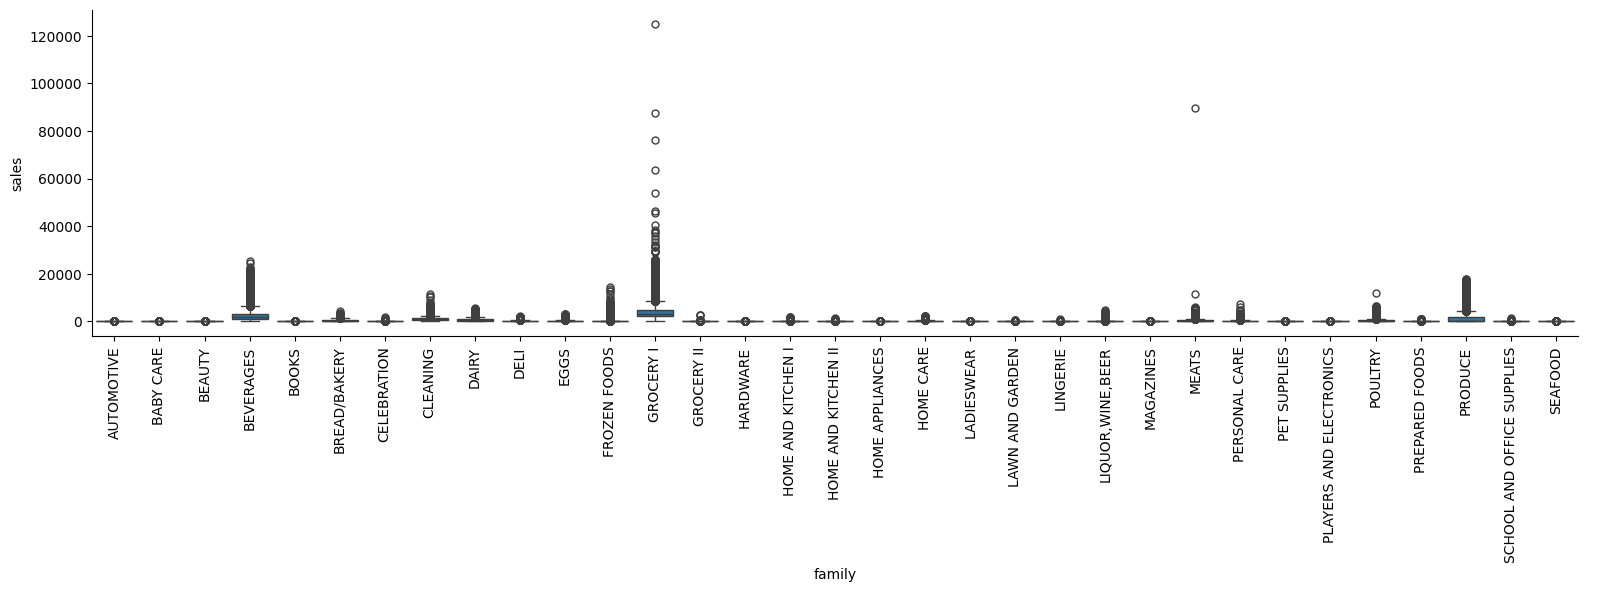

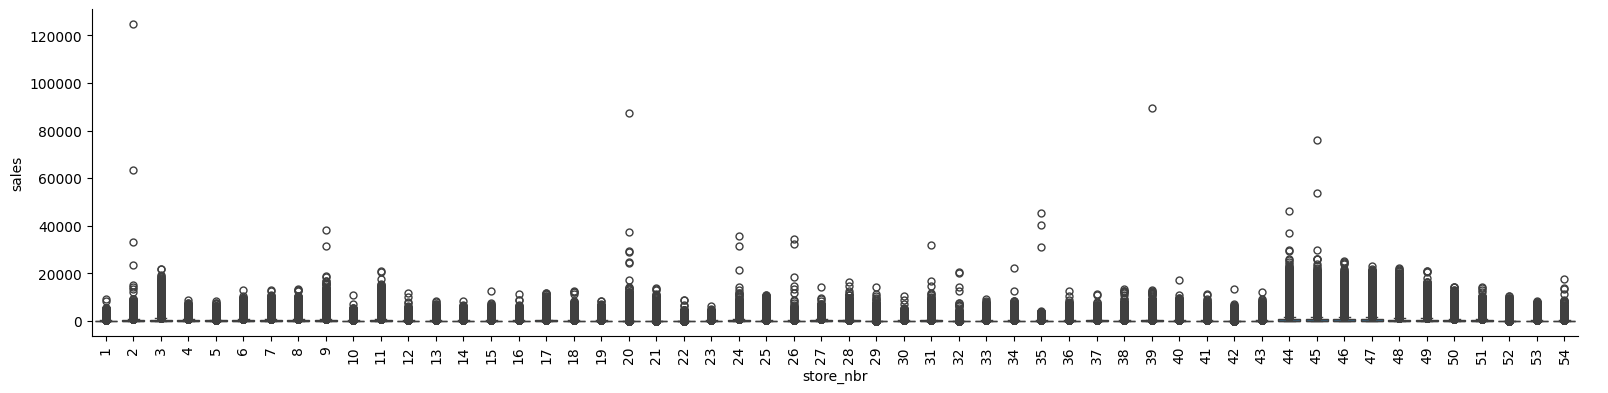

In [29]:
grp_boxplot(train,clm = ['family','store_nbr'],target = 'sales')

In [30]:
def grp_familylineplot(tbl, family):
    fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (16,4))
    plot_data = tbl[tbl["family"].isin(family)]
    plot_data = plot_data.groupby(by = ["date","family"],as_index=False)["sales"].mean()
    sns.lineplot(data = plot_data, x="date", y= "sales", hue="family", ax = axs)
    plt.show()

def grp_storelineplot(tbl, store_nbr):
    fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (16,4))
    plot_data = tbl[tbl["store_nbr"].isin(store_nbr)]
    plot_data = plot_data.groupby(by = ["date","store_nbr"],as_index=False)["sales"].mean()
    sns.lineplot(data = plot_data, x="date", y= "sales", hue="store_nbr", ax = axs)
    plt.show()


##### There was Non Stocking problem for Celebration, hOMe and kitchen I, hOMe and kitchen Ii, Home Care, Ladieswear, Magazines, Players and Electronics, Pets and Supplies during the period of 2013


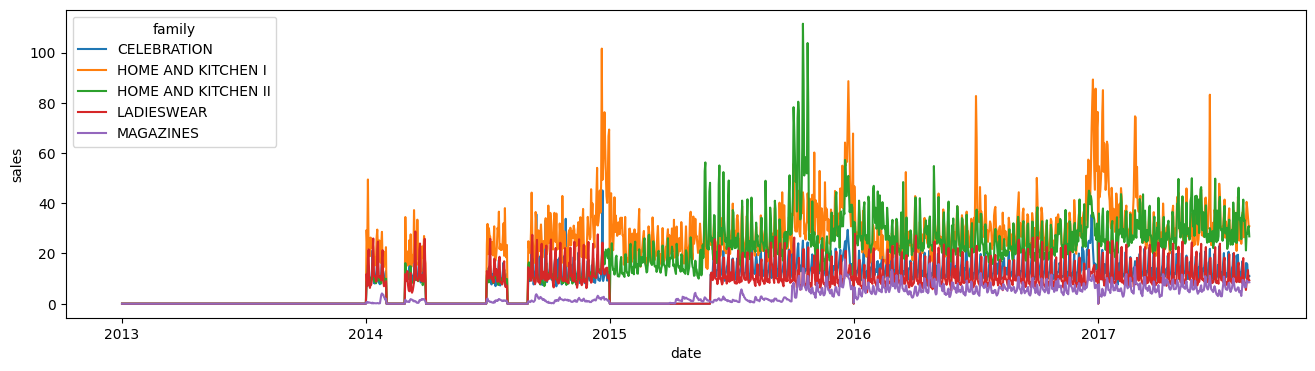

In [31]:
grp_familylineplot(train, family=["CELEBRATION", "MAGAZINES","HOME AND KITCHEN I", "HOME AND KITCHEN II", "LADIESWEAR", "MAGAZINES"])

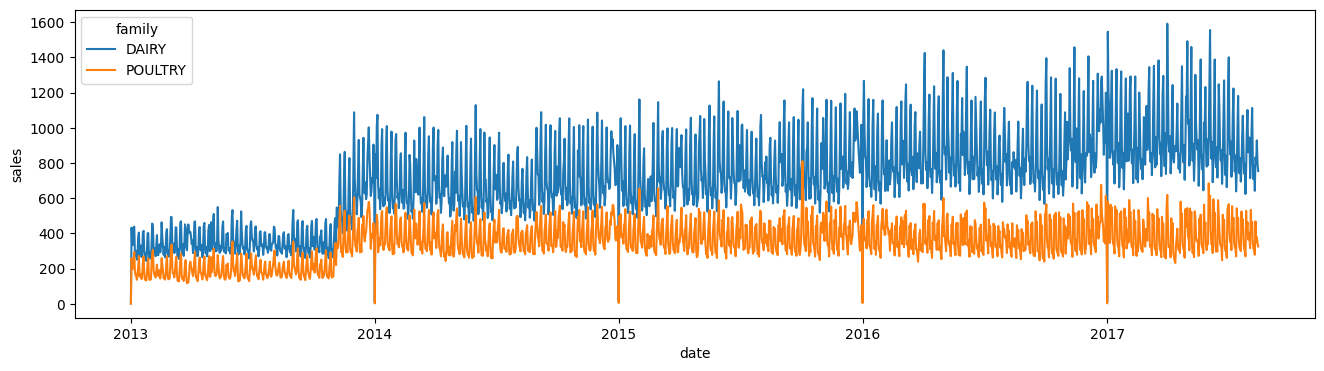

In [32]:
grp_familylineplot(train, family=["DAIRY", "POULTRY"])

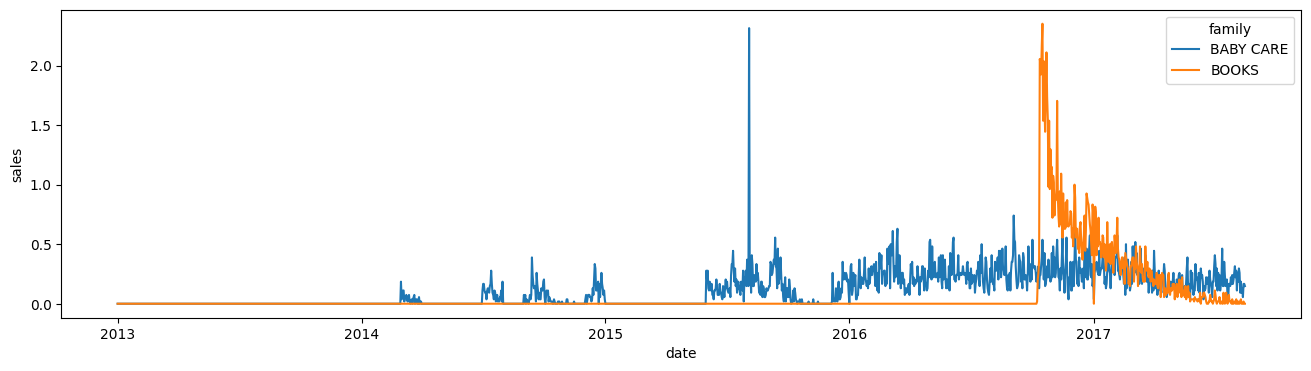

In [33]:
## there was understocking for the products like BOOKS and BABY CARE
grp_familylineplot(train, family=["BOOKS", "BABY CARE"])

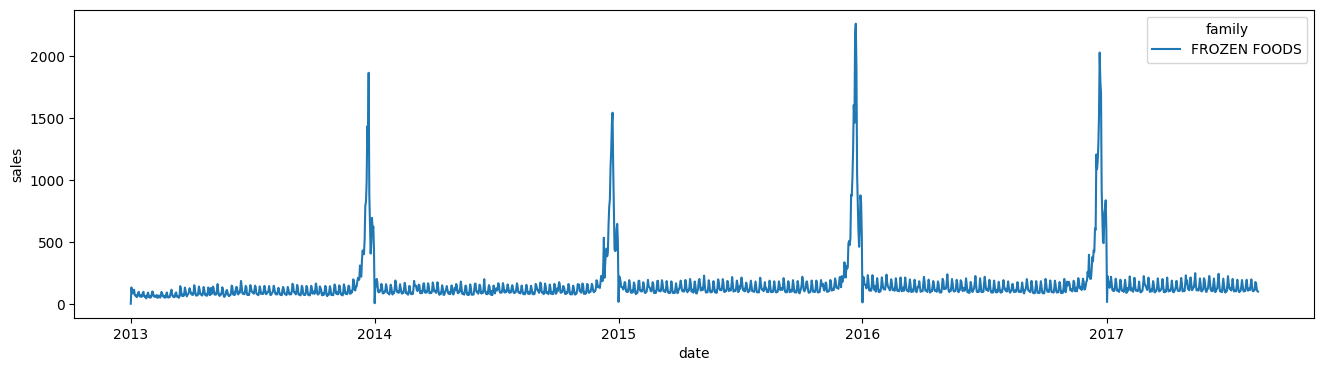

In [34]:
## Increase in the sales for frozen food during last month of the year
grp_familylineplot(train, family=["FROZEN FOODS"])

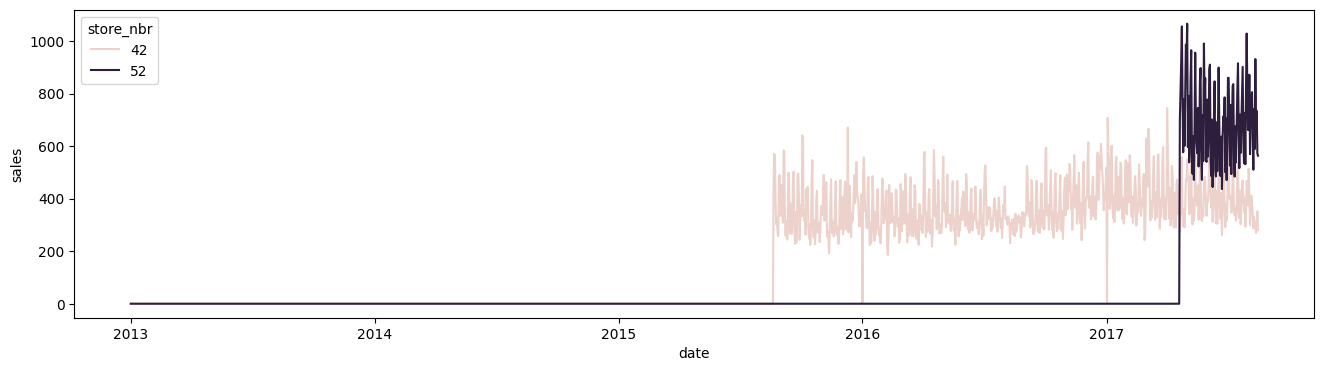

In [35]:
## 24,25,29,30,42,52,53 : these stores were closed in between
grp_storelineplot(train, [42,52])

- Quito sales is more than any city as Quito is the capital of the Ecaquador.
- Pichonchio sales are greater. It's because Quito is in the Pichonchio.

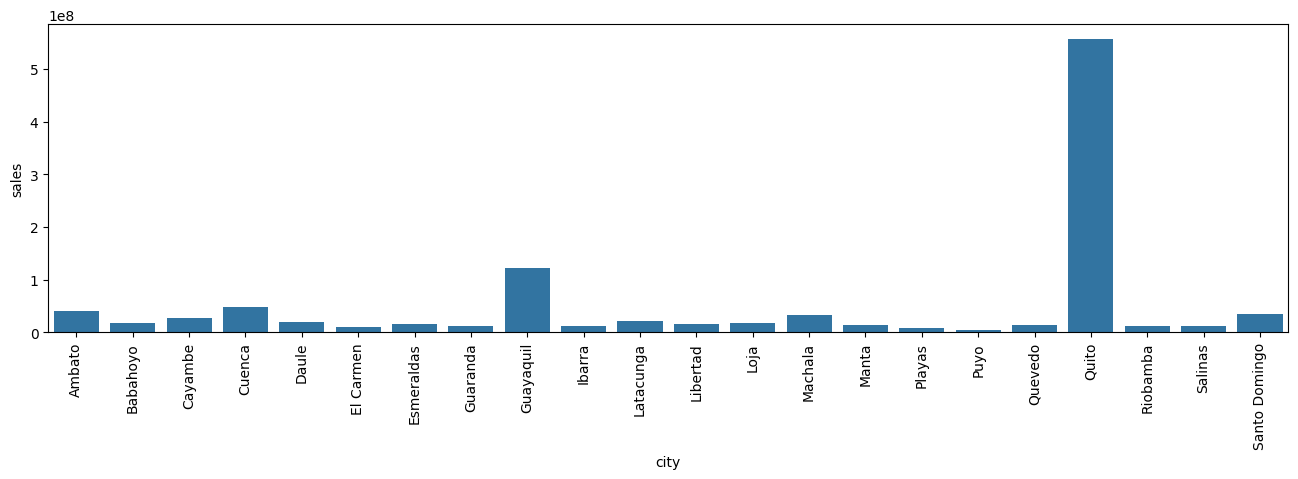

In [36]:
def city_wise_sales(train, stores, clm):

    data1 = pd.merge(train, stores, left_on=["store_nbr"], right_on = ["store_nbr"], how = "left")
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize = (16,4))
    plot_data = data1.groupby(by = [clm], as_index=False)["sales"].sum()    
    sns.barplot(data=plot_data, x = clm, y = "sales", ax= axs)
    axs.tick_params(axis = 'x', rotation = 90)
    plt.show()

city_wise_sales(train, stores, 'city')
    

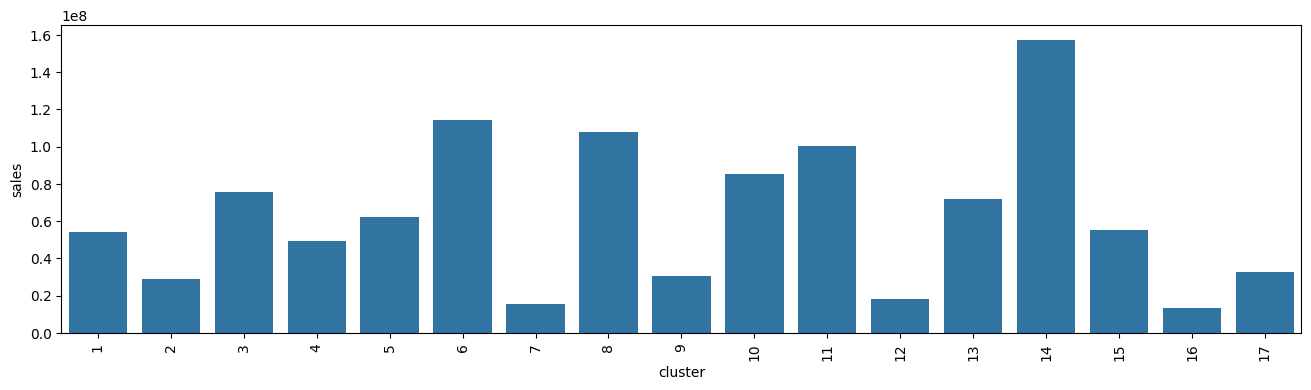

In [37]:
city_wise_sales(train, stores, 'cluster')

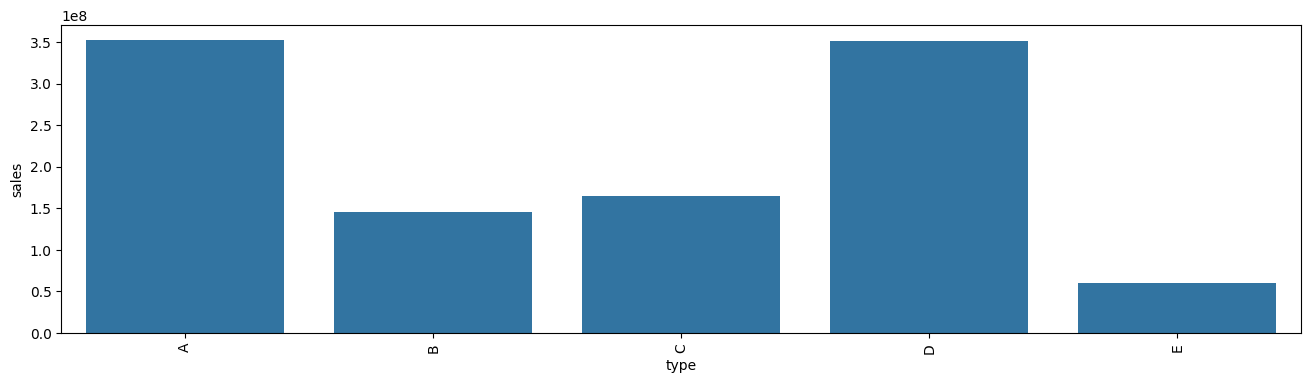

In [38]:
city_wise_sales(train, stores, 'type')

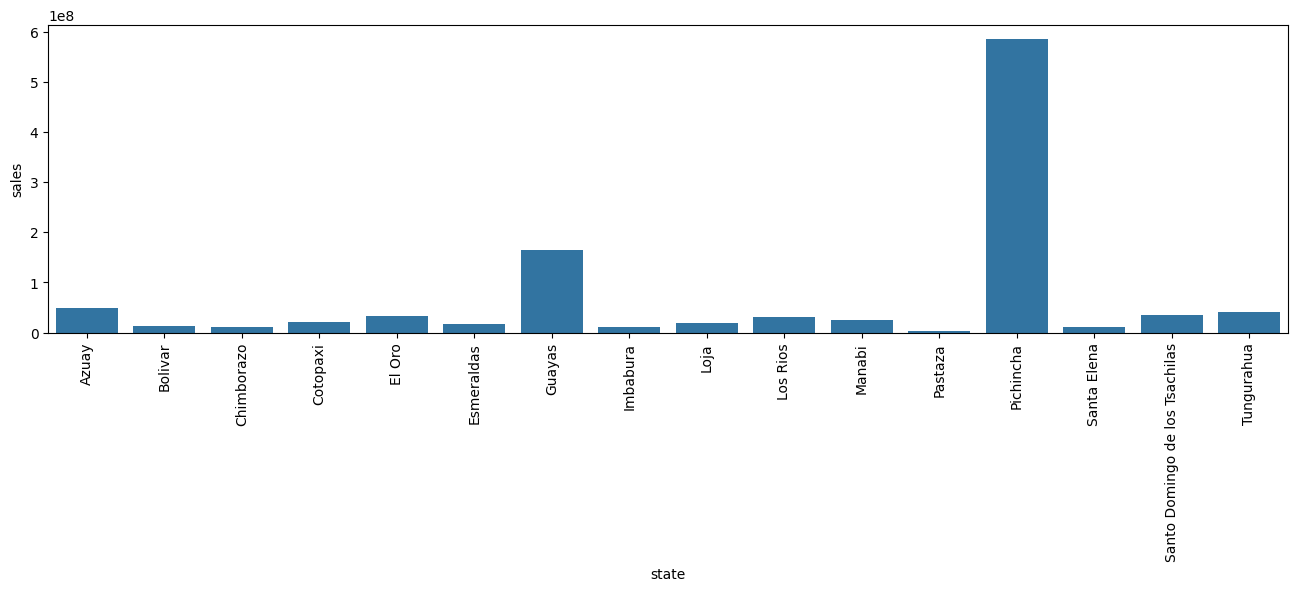

In [39]:
city_wise_sales(train, stores, 'state')

#### Sales is right skewed due to the number of zeores

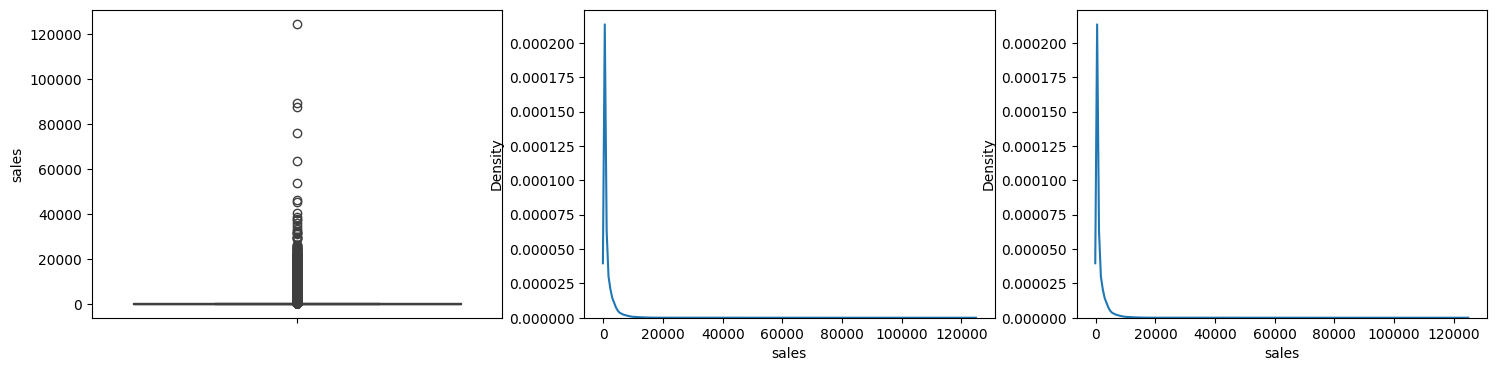

In [40]:
fig, axs = plt.subplots(figsize = (18,4), nrows = 1, ncols = 3)
sns.boxplot(train["sales"],ax = axs[0])
sns.kdeplot(train["sales"],ax = axs[1])
sns.kdeplot(train["sales"],ax = axs[2])
plt.show()

### On promotion and Sales
--- On Promotion doesn't have much effect on Stores sales.

--- Pattern in Beverages and Produce is due to the change in Oil Prices.

--- Meats and Frozen foods have followed same pattern

--- Individual Family follows same pattern for all stores

### Autocorrelation in train data

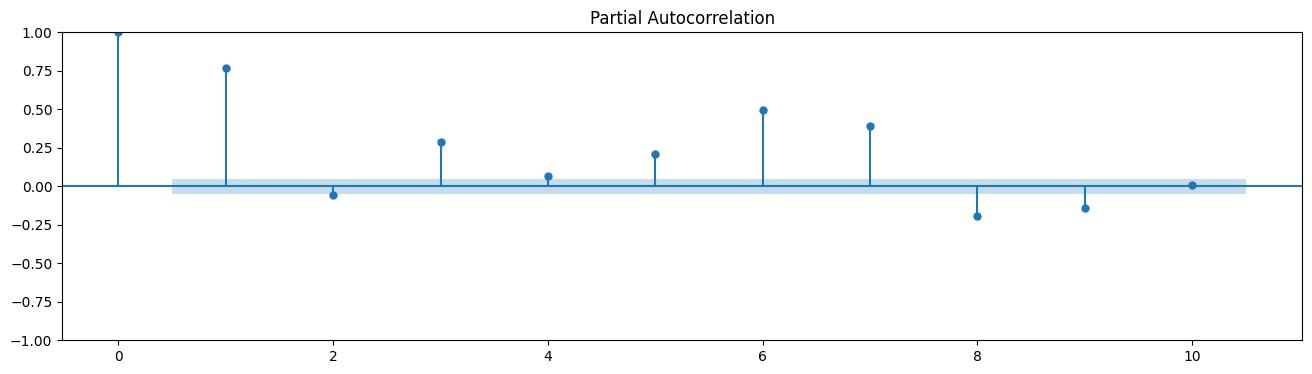

In [41]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(16,4))
plot_pacf(train.groupby(["date"])["sales"].mean(), lags = 10 , ax = axs)
plt.show()

### Creating Seasonal features

In [42]:
def calculate_VIF_factor(data):
    """
    data : table with independent variable data
    
    """
    result = pd.DataFrame({"Variable":data.columns,"VIF":[variance_inflation_factor(data.values,i) for i in range(data.shape[1])]})

    return result

In [43]:
## test data pre processing

def data_preprocessing_2(train,test,transactions, Oil, stores,Holiday_events):

    """
    train : train data for sales
    test : test data for sales
    transactions : number of trnasaction for the same time period
    Oil : Oil prices for the same time period
    Stores : Store information
    Holiday_Events : Holiday Event during the same time period
     
    """
    
    stores = string_processing(stores,['city','state'])

    Local,Regional, National = Holiday_func(Holiday_events)

    train_data = merge_tables(train,transactions, Oil, stores, National, Local, Regional)
    test_data = merge_tables(test,transactions, Oil, stores, National, Local, Regional)

    family_rank = train_data.groupby(by = ["family"], as_index=False)["sales"].mean().sort_values(by = ["sales"], ascending=False)\
        .reset_index(drop = True).reset_index().drop(columns= ["sales"]).rename(columns = {"index":"family_rank"})
    
    store_rank = train_data.groupby(by = ["store_nbr"], as_index=False)["sales"].mean().sort_values(by = ["sales"], ascending=False)\
        .reset_index(drop = True).reset_index().drop(columns= ["sales"]).rename(columns = {"index":"store_rank"})

    train_data = pd.merge(train_data, family_rank, left_on = ["family"], right_on=["family"])
    train_data = pd.merge(train_data, store_rank, left_on = ["store_nbr"], right_on=["store_nbr"])
    
    test_data = pd.merge(test_data, family_rank, left_on = ["family"], right_on=["family"])
    test_data = pd.merge(test_data, store_rank, left_on = ["store_nbr"], right_on=["store_nbr"])
    

    train_data = date_treatment(train_data)
    test_data = date_treatment(test_data)
    train_data = add_lag_features(train_data)

    future_lags = lag_for_prediction(train)
    test_data = pd.merge(test_data, future_lags, left_on = ["date","store_nbr", "family"], right_on=["date","store_nbr", "family"], how="left")

    seasonality = add_seasonality(pd.period_range('2013-01-01', '2017-08-31'), freq=[3.5,7,30,365], order=1)
    trend_line = add_trend(seasonality[["date"]])

    train_data_seas = pd.merge(train_data, seasonality, left_on="date", right_on ="date", how="left")
    train_data_seas = pd.merge(train_data_seas, trend_line, left_on="date", right_on ="date", how="left")
    train_data_seas.drop(columns=['state', 'id', 'family','store_nbr','city', 'locale_name_x','Day_Name','type','cluster',"locale_name_y", "locale_name"], inplace=True)

    test_data_seas = pd.merge(test_data, seasonality, left_on="date", right_on ="date", how="left")
    test_data_seas = pd.merge(test_data_seas, trend_line, left_on="date", right_on ="date", how="left")
    test_data_seas.drop(columns=['state', 'date','family','store_nbr','city', 'locale_name_x','Day_Name','type','cluster',"locale_name_y", "locale_name"], inplace=True)

    return train_data_seas,  test_data_seas

In [44]:
def evaluate_model(model1, time_period_table, log = False):
    
    '''
    
    model1 : Model with its specifications
    time_period_table : preprocessed table
    log : if log transformation has been applied on the model

    '''
    
    date = time_period_table[["date"]]
    if log:
        Y = np.log(time_period_table["sales"] + 1)
    else:
        Y = time_period_table["sales"]
    X = time_period_table.drop(columns = ["date", "sales"])

    len_1_mnth = len(date[date["date"] >= '2017-07-16'])

    seas_train, seas_test = X[:-len_1_mnth], X[-len_1_mnth:]
    Y_seas_train, Y_seas_test = Y[:-len_1_mnth], Y[-len_1_mnth:]    

    pred_model = model1.fit(seas_train,Y_seas_train)

    y_pred = [max(0,i) for i in pred_model.predict(seas_test)]
    y_fitted = [max(0,i) for i in pred_model.predict(seas_train)]

    if log:
        y_pred = np.exp(y_pred) - 1
        y_fitted = np.exp(y_fitted) - 1
        Y_seas_train = np.exp(Y_seas_train) - 1
        Y_seas_test = np.exp(Y_seas_test) - 1
        print("Train R2 score : ",r2_score(Y_seas_train,y_fitted),"Test R2 score : ",r2_score(Y_seas_test,y_pred))
        Log_error = RMSLE(Y_seas_test,y_pred)
    else:
        print("Train R2 score : ",r2_score(Y_seas_train,y_fitted),"Test R2 score : ",r2_score(Y_seas_test,y_pred))
        Log_error = RMSLE(Y_seas_test,y_pred)

    result = pd.concat([time_period_table[["date", "store_rank"]][-len_1_mnth:].reset_index(drop = True),Y_seas_test.reset_index(drop = True),pd.Series(y_pred)],axis = 1)
    result.columns = ["date", "store_rank", "sales", "pred"]

    Feature_Importance = pd.DataFrame({'Features': model1.feature_names_in_,'Importance':model1.feature_importances_})
    Feature_Importance = Feature_Importance.sort_values(by = ["Importance"], ascending = False).reset_index(drop=True)

    return result, Log_error, Feature_Importance

In [45]:
def plot_result(df):
    '''
    df : result dataframe with actual and predicted values
    '''
    fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (16,4))
    sns.lineplot(data=df, x="date", y = "sales", ci=False, label ="actual", ax = axs)
    sns.lineplot(data=df, x="date", y = "pred", ci=False, label ="pred", ax= axs)
    plt.show()

In [ ]:
train_data_seas_2,test_data_seas_2  = data_preprocessing_2(train,test,transactions, Oil, stores,Holiday_events)

### First Approach

In [ ]:
model1 = xgb.XGBRegressor(n_estimators = 1000, learning_rate = 0.1, max_depth = 7, min_child_weight = 100, sub_sample=0.8, colsample_bytree = 0.9)
result_1, error_1, Feature_Importance_1 = evaluate_model(model1, train_data_seas_2, log =False)

Train R2 score :  0.9752013716481052 Test R2 score :  0.9728680707543319


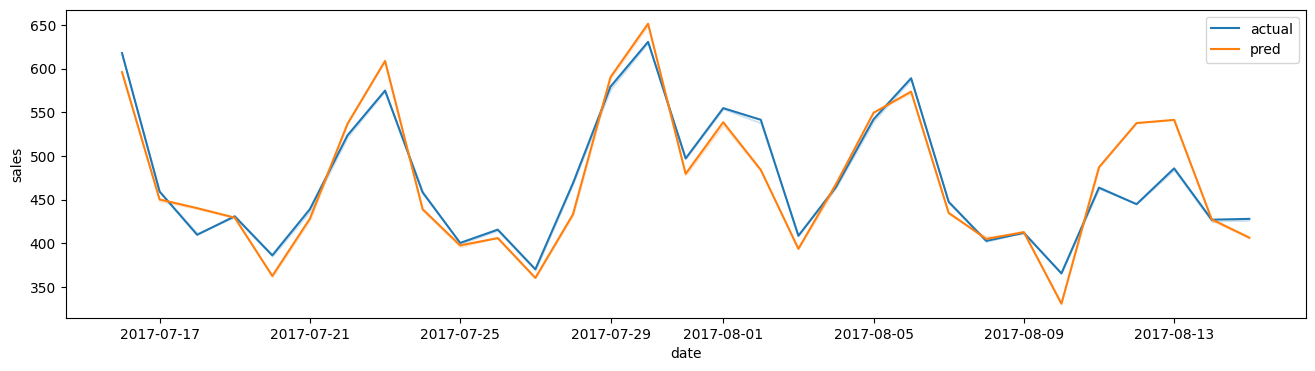

In [ ]:
plot_result(result_1)

### Second Approach

In [ ]:
def outliers_removal(df, clm):
    '''

    df : Preprocessed DataFrame
    clm : numerical variable to calculate the outliers
    
    '''

    first_quartile = df[clm].quantile(0.25)
    third_quantile = df[clm].quantile(0.75)

    IQR = third_quantile - first_quartile

    LB = first_quartile - 1.5*IQR
    UB = third_quantile + 1.5*IQR

    df = df[(df[clm] >= LB) & (df[clm] <= UB)]

    return df

In [ ]:
train_data_seas_4 = train_data_seas_2.copy()
train_data_seas_4  = outliers_removal(train_data_seas_4,'sales')

In [ ]:
model1 = xgb.XGBRegressor(n_estimators = 100, learning_rate = 0.1, max_depth = 4, min_child_weight = 100, sub_sample=0.8, colsample_bytree = 0.9)
result_2, error_2, Feature_Importance_2 = evaluate_model(model1, train_data_seas_4, log =False)

Train R2 score :  0.9400698673040131 Test R2 score :  0.9419670132544364


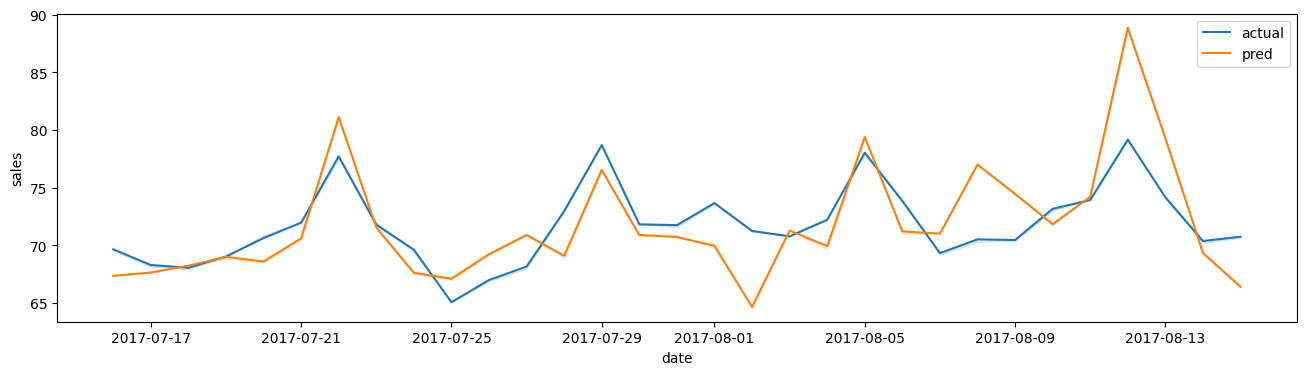

In [ ]:
plot_result(result_2)

### Third Approach

In [ ]:
train_data_seas_4 = train_data_seas_2.copy()

model1 = xgb.XGBRegressor(n_estimators = 2000, learning_rate = 0.05, max_depth = 9, min_child_weight = 10, sub_sample=0.8, colsample_bytree = 0.8)
result_3, error_3, Feature_Importance_3 = evaluate_model(model1, train_data_seas_4, log =True)

Train R2 score :  0.9748580116555406 Test R2 score :  0.9748571497188604


In [ ]:
error_3

0.38536888446320083

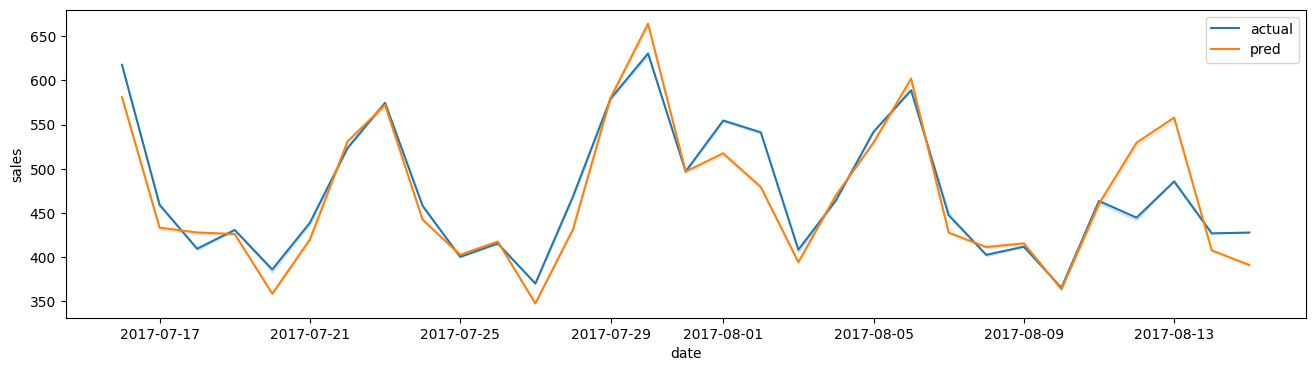

In [ ]:
def plot_result(df):
    fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (16,4))
    sns.lineplot(data=df, x="date", y = "sales", ci=False, label ="actual", ax = axs)
    sns.lineplot(data=df, x="date", y = "pred", ci=False, label ="pred", ax= axs)
    plt.show()

plot_result(result_1)

In [ ]:
def submission(df, model, log = False):
    """
    df : test data with the necessary variables
    model : any model that has been trained on the train data
    """
    
    test_id = df[["id"]]
    test_data = df.drop(columns = ["id"])
    model_pred = pd.DataFrame({"sales":model.predict(test_data)})

    if log:
        model_pred["sales"] = np.exp(model_pred["sales"]) -1

    submission_data = pd.concat([test_id,model_pred], axis=1)

    return submission_data

In [ ]:
submission(test_data_seas_2, model1, log = True)

NameError: name 'test_data_seas_2' is not defined